### In this new : 
I am using the dataset with the 1:1's !

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from icecream import ic
import statsmodels.api as sm 
from statsmodels.regression import linear_model
from utils import residual_vs_covariate

In [2]:
data = pd.read_csv('../data/df-time-agg.csv')
data = data[data["person"]!="ingeborgR"]
data = data[(data["person"] != "adamF") | (data["coin"] != "0.05EUR") | (data["agg"] != 84)]


data_expanded = data.copy()
data_expanded['r'] = data["heads_heads"]+(data['N_start_tails_up']-data["tails_heads"])
data_expanded['m'] = data['N_start_tails_up']+data['N_start_heads_up']
data_expanded['rom'] = data_expanded['r'] / data_expanded['m']
data_expanded['weights'] = (4*data_expanded['m'])

print(len(data_expanded))

3409


In [3]:
WLS_model_0 = linear_model.WLS.from_formula(formula="(rom) ~ 1",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]), data=data_expanded)
WLS_model_1 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded)
WLS_model_2 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded) # Best AIC 
WLS_model_3 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg+C(coin)",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded) 
WLS_model_4 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg+C(person):C(coin)",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded) # Best LRT
result_WLS_0 = WLS_model_0.fit()
result_WLS_1 = WLS_model_1.fit()
result_WLS_2 = WLS_model_2.fit()
result_WLS_3 = WLS_model_3.fit()
result_WLS_4 = WLS_model_4.fit()
print(f"\nAIC for the WLS_0: {result_WLS_0.aic:.2f}")
print(f"\nAIC for the WLS_1: {result_WLS_1.aic:.2f}")
print(f"\nAIC for the WLS_2: {result_WLS_2.aic:.2f}")
print(f"\nAIC for the WLS_3: {result_WLS_3.aic:.2f}")
print(f"\nAIC for the WLS_4: {result_WLS_4.aic:.2f}")
# lower AIC is better !
# We select model 2 with persons only !


AIC for the WLS_0: -10288.62

AIC for the WLS_1: -10435.50

AIC for the WLS_2: -10448.38

AIC for the WLS_3: -10419.17

AIC for the WLS_4: -10324.40


In [4]:
minimal_aic = min(result_WLS_0.aic, result_WLS_1.aic, result_WLS_2.aic,  result_WLS_3.aic, result_WLS_4.aic)

# Create a table for model comparison
model_data = {
    "Model Formula (RHS)": [
        "1",
        "1 + C(person)",
        "1 + C(person) + agg",
        "1 + C(person) + agg + C(coin)",
        "1 + C(person) + agg + C(person):C(coin)"
    ],
    "AIC": [
        result_WLS_0.aic - minimal_aic,
        result_WLS_1.aic - minimal_aic,
        result_WLS_2.aic - minimal_aic,
        result_WLS_3.aic - minimal_aic,
        result_WLS_4.aic - minimal_aic,
    ],
}

# Create a DataFrame
comparison_table = pd.DataFrame(model_data)

# Generate LaTeX table
table_latex = comparison_table.to_latex(
    index=False,
    float_format="{:.2f}".format,
    caption="Model comparison based on AIC values.",
    label="tab:model-comparison",
    position="htb",
    column_format="lc"
)

# Modify the LaTeX string to add centering
caption_index = table_latex.find(r"\caption")
table_latex = table_latex[:caption_index] + r"\centering" + "\n" + table_latex[caption_index:]

# Display the LaTeX table
print(table_latex)

\begin{table}[htb]
\centering
\caption{Model comparison based on AIC values.}
\label{tab:model-comparison}
\begin{tabular}{lc}
\toprule
Model Formula (RHS) & AIC \\
\midrule
1 & 159.76 \\
1 + C(person) & 12.89 \\
1 + C(person) + agg & 0.00 \\
1 + C(person) + agg + C(coin) & 29.21 \\
1 + C(person) + agg + C(person):C(coin) & 123.98 \\
\bottomrule
\end{tabular}
\end{table}



#### Here to do the final ANOVA-AIC for WLS

In [5]:
table = sm.stats.anova_lm(result_WLS_3, typ=2)
print(table)
row_labels = table.index.tolist()
row_labels[1], row_labels[2] = row_labels[2], row_labels[1] # Swap r2 and r3 labls
table.iloc[[1, 2]] = table.iloc[[2, 1]].values  # Swap the values of rows
table.index = row_labels  # Assign the new index order

empty_row = pd.DataFrame([{}], columns=table.columns)  # Empty row
table = pd.concat([empty_row, table], ignore_index=True)
aic_differences = [result_WLS_0.aic - minimal_aic, result_WLS_1.aic - minimal_aic,result_WLS_2.aic - minimal_aic, result_WLS_3.aic - minimal_aic, 0]
# Add the column to the DataFrame
table["Delta AIC"] = aic_differences
print(table)
comparison_table = table

# Generate LaTeX table
table_latex = comparison_table.to_latex(
    index=False,
    float_format="{:.2f}".format,
    formatters={'PR(>F)': lambda x: f'{x:.2e}'},
    caption="Model comparison based on AIC values.",
    label="tab:model-comparison",
    position="htb",
    column_format="lc"
)

# Modify the LaTeX string to add centering
caption_index = table_latex.find(r"\caption")
table_latex = table_latex[:caption_index] + r"\centering" + "\n" + table_latex[caption_index:]

# Display the LaTeX table
print(table_latex)

'''
\begin{table}[htb]
\centering
\caption{ANOVA (type II)}
\label{tab:model-comparison}
\begin{tabular}{lccccc}
\toprule
Term & RSS & df & F & PR(>F) & Delta AIC \\
\midrule
1 & - & - & - & - & 159.76 \\
person & 213.78 & 46.00 & 4.31 & 0.00 & 12.89 \\
coin & 7.65 & 1.00 & 7.10 & 0.01 & 0.00 \\
agg & 57.95 & 42.00 & 1.28 & 0.11 & 29.21 \\
Residual & 3576.62 & 3319.00 & - & - & 0.00 \\
\bottomrule
\end{tabular}
\end{table}
'''



             sum_sq      df         F        PR(>F)
C(person)  0.532488    46.0  4.312697  4.467021e-20
C(coin)    0.144344    42.0  1.280398  1.070507e-01
agg        0.019058     1.0  7.100152  7.745041e-03
Residual   8.908624  3319.0       NaN           NaN
     sum_sq      df         F        PR(>F)   Delta AIC
0       NaN     NaN       NaN           NaN  159.764090
1  0.532488    46.0  4.312697  4.467021e-20   12.885935
2  0.019058     1.0  7.100152  7.745041e-03    0.000000
3  0.144344    42.0  1.280398  1.070507e-01   29.207756
4  8.908624  3319.0       NaN           NaN    0.000000
\begin{table}[htb]
\centering
\caption{Model comparison based on AIC values.}
\label{tab:model-comparison}
\begin{tabular}{lc}
\toprule
sum_sq & df & F & PR(>F) & Delta AIC \\
\midrule
NaN & NaN & NaN & NaN & 159.76 \\
0.53 & 46.00 & 4.31 & 4.47e-20 & 12.89 \\
0.02 & 1.00 & 7.10 & 7.75e-03 & 0.00 \\
0.14 & 42.00 & 1.28 & 1.07e-01 & 29.21 \\
8.91 & 3319.00 & NaN & NaN & 0.00 \\
\bottomrule
\end{tabular

'\n\x08egin{table}[htb]\n\\centering\n\\caption{ANOVA (type II)}\n\\label{tab:model-comparison}\n\x08egin{tabular}{lccccc}\n\toprule\nTerm & RSS & df & F & PR(>F) & Delta AIC \\\n\\midrule\n1 & - & - & - & - & 159.76 \\\nperson & 213.78 & 46.00 & 4.31 & 0.00 & 12.89 \\\ncoin & 7.65 & 1.00 & 7.10 & 0.01 & 0.00 \\\nagg & 57.95 & 42.00 & 1.28 & 0.11 & 29.21 \\\nResidual & 3576.62 & 3319.00 & - & - & 0.00 \\\n\x08ottomrule\n\\end{tabular}\n\\end{table}\n'

In [6]:
# LRT 

#model 0: "1",     
#model 1: "1 + C(person)",      
#model 2: "1 + C(person) + agg", better than 3          
#model 3: "1 + C(person) + agg + C(coin)",       
#model 4: "1 + C(person) + agg + C(person):C(coin)"      

print(result_WLS_1.compare_lr_test(result_WLS_0, large_sample=False)) # 1 is better

print(result_WLS_2.compare_lr_test(result_WLS_1, large_sample=False)) # 2 is better

print(result_WLS_3.compare_lr_test(result_WLS_2, large_sample=False)) # 2 is better

print(result_WLS_4.compare_lr_test(result_WLS_2, large_sample=False)) # 2 is better


# Table for LRT tests
_,LRT_1_0,_ = result_WLS_1.compare_lr_test(result_WLS_0, large_sample=False)
_,LRT_2_1,_  = result_WLS_2.compare_lr_test(result_WLS_1, large_sample=False)
_,LRT_3_2,_  = result_WLS_3.compare_lr_test(result_WLS_2, large_sample=False)
_,LRT_4_2,_  = result_WLS_4.compare_lr_test(result_WLS_2, large_sample=False)

# Create a table for model comparison
model_data = {
    "Tested Model": [
        "1 + C(person)",  # Model 1
        "1 + C(person) + agg",  # Model 2
        "1 + C(person) + agg + C(coin)",  # Model 3
        "1 + C(person) + agg + C(person):C(coin)"  # Model 4
    ],

    "Restricted Model": [
        "1",  # Compared to Model 0
        "1 + C(person)",  # Compared to Model 1
        "1 + C(person) + agg",  # Compared to Model 2
        "1 + C(person) + agg",  # Compared to Model 2
    ],

    "p-value": [
        LRT_1_0,
        LRT_2_1,
        LRT_3_2,
        LRT_4_2,
    ],
}

lrt_comparison_table = pd.DataFrame(model_data)
print('Table for LRTs : ')
LRT_string = lrt_comparison_table.to_latex(index=True, 
                columns=['Tested Model', 'Restricted Model', 'p-value'], 
                header=['Tested model', 'Restricted Model', 'p-value'],
                float_format='{:.2f}'.format,
                caption='LRTs table',
                label='tab:LRT-model-comparison',
                position='htb',
                column_format='lcc')
caption_index = LRT_string.find(r'\caption')
deviance_string = LRT_string[:caption_index] + r'\centering' + '\n' + LRT_string[caption_index:]
print(LRT_string)

(np.float64(238.87815532385503), np.float64(7.28039793891565e-28), np.float64(46.0))
(np.float64(14.885934995327261), np.float64(0.00011421137146345186), np.float64(1.0))
(np.float64(54.7922437198813), np.float64(0.0891482226803654), np.float64(42.0))
(np.float64(202.01628789149981), np.float64(0.020406475246802103), np.float64(163.0))
Table for LRTs : 
\begin{table}[htb]
\caption{LRTs table}
\label{tab:LRT-model-comparison}
\begin{tabular}{lcc}
\toprule
 & Tested model & Restricted Model & p-value \\
\midrule
0 & 1 + C(person) & 1 & 0.00 \\
1 & 1 + C(person) + agg & 1 + C(person) & 0.00 \\
2 & 1 + C(person) + agg + C(coin) & 1 + C(person) + agg & 0.09 \\
3 & 1 + C(person) + agg + C(person):C(coin) & 1 + C(person) + agg & 0.02 \\
\bottomrule
\end{tabular}
\end{table}



### ANOVA of selected model

In [7]:
table = sm.stats.anova_lm(result_WLS_3, typ=2) 
print(table)
print('Table for models comparison : ')
deviance_string = table.to_latex(index=True, 
                columns=['sum_sq', 'df', 'F', 'PR(>F)'], 
                header=['SS', 'DoF', 'F-statistic', 'p-value'],
                #formatters={'formula': lambda x: r'\texttt{'+x+r'}'},
                float_format='{:.2f}'.format,
                caption='ANOVA table',
                label='tab:model-comparison',
                position='htb',
                column_format='lcccc')
caption_index = deviance_string.find(r'\caption')
deviance_string = deviance_string[:caption_index] + r'\centering' + '\n' + deviance_string[caption_index:]
print(deviance_string)

             sum_sq      df         F        PR(>F)
C(person)  0.532488    46.0  4.312697  4.467021e-20
C(coin)    0.144344    42.0  1.280398  1.070507e-01
agg        0.019058     1.0  7.100152  7.745041e-03
Residual   8.908624  3319.0       NaN           NaN
Table for models comparison : 
\begin{table}[htb]
\centering
\caption{ANOVA table}
\label{tab:model-comparison}
\begin{tabular}{lcccc}
\toprule
 & SS & DoF & F-statistic & p-value \\
\midrule
C(person) & 0.53 & 46.00 & 4.31 & 0.00 \\
C(coin) & 0.14 & 42.00 & 1.28 & 0.11 \\
agg & 0.02 & 1.00 & 7.10 & 0.01 \\
Residual & 8.91 & 3319.00 & NaN & NaN \\
\bottomrule
\end{tabular}
\end{table}



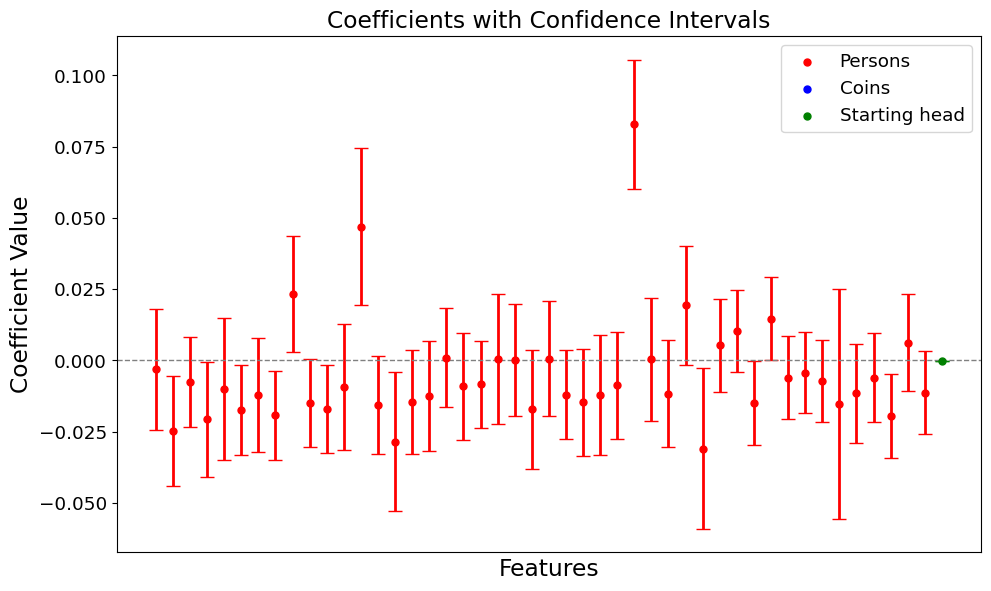

In [8]:
import re
# the introductory model 
result_WLS = result_WLS_2

coefficients = result_WLS.params
conf_int = result_WLS.conf_int()

# remove the constant coefficient : 
coefficients = result_WLS.params[1:]  # Exclude the first coefficient
conf_int = result_WLS.conf_int()[1:] 
conf_int_inf= list(conf_int[0])
conf_int_sup= list(conf_int[1])
feature_names = result_WLS.model.exog_names[1:]

# Determine colors based on the feature names
colors = [
    'red' if 'person' in feature else 'blue' if 'coin' in feature else "green"
    for feature in feature_names
]

# Create the plot
plt.figure(figsize=(10, 6))

# Clean the feature names
for i, (feature, coef, color) in enumerate(zip(feature_names, coefficients, colors)):
    plt.errorbar(
        x=i,
        y=coef,
        yerr=[[coef - conf_int_inf[i]], [conf_int_sup[i] - coef]],
        fmt='o',
        ecolor=color,  # Use the determined color for error bars
        color=color,   # Use the determined color for points
        capsize=5
    )

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Create a legend
plt.scatter([], [], color='red', label='Persons')   # Red legend entry
plt.scatter([], [], color='blue', label='Coins')    # Blue legend entry
plt.scatter([], [], color='green', label='Starting head')  # Green legend entry
plt.legend(loc='upper right')

# Add labels and title
plt.xlabel('Features')
plt.xticks([])
plt.ylabel('Coefficient Value')
plt.title('Coefficients with Confidence Intervals')
plt.tight_layout()
plt.show()

# selected model is 1+C(person)+agg

<Figure size 800x600 with 0 Axes>

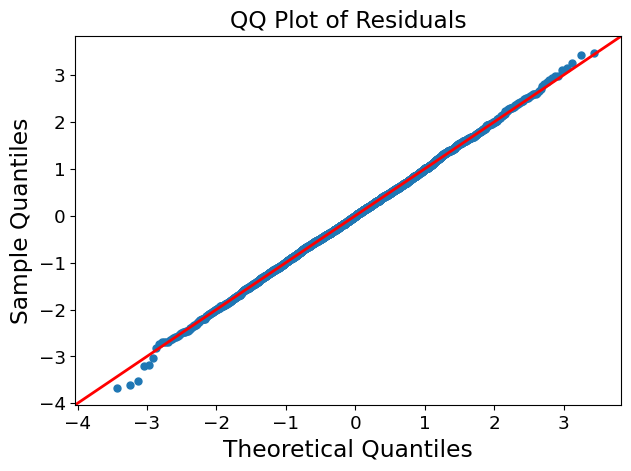

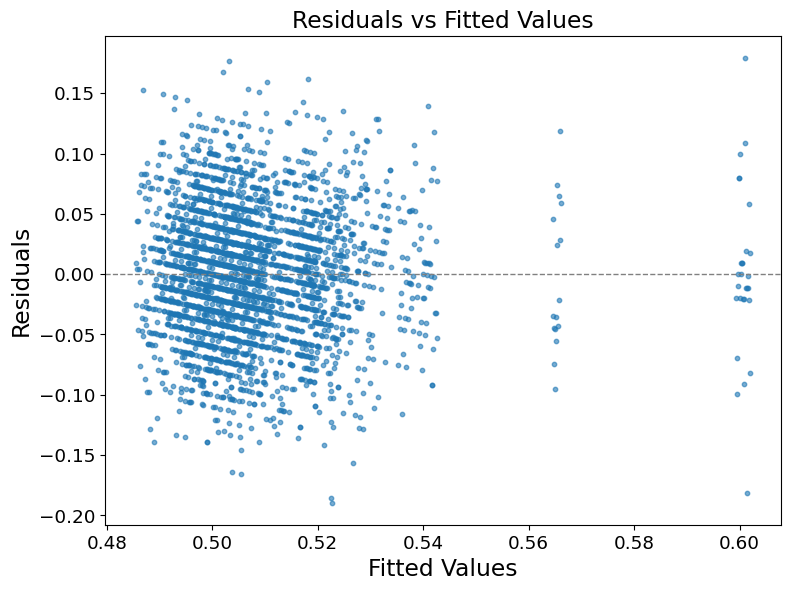

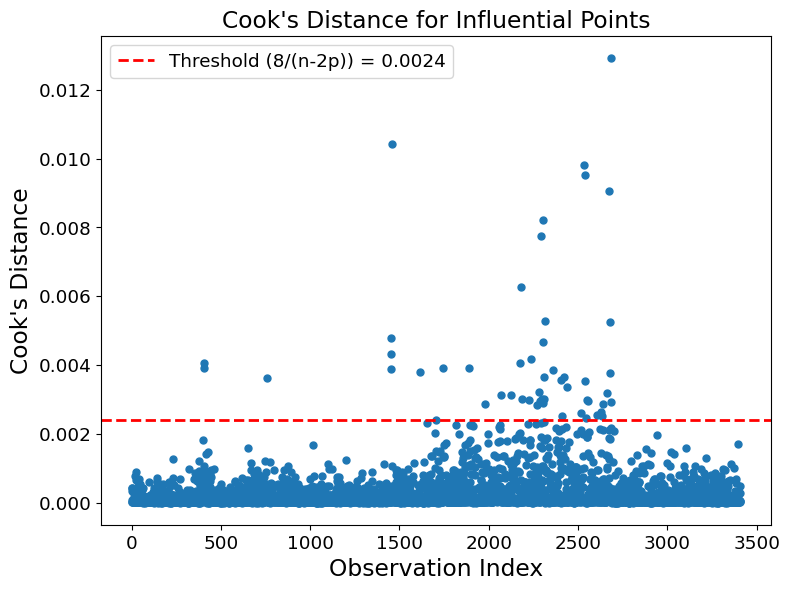

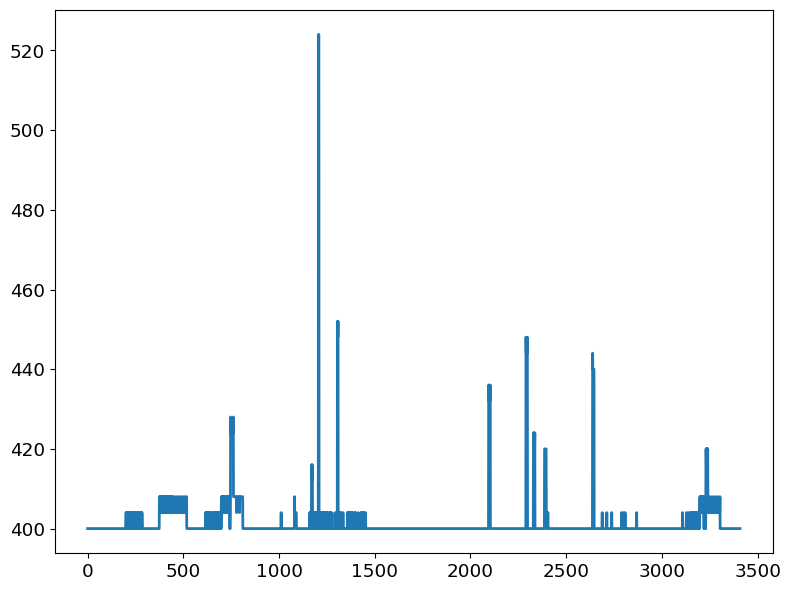

In [9]:
from statsmodels.stats.outliers_influence import OLSInfluence

WLS_model_complete = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg",weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  data=data_expanded) # Best LRT
result_WLS_complete = WLS_model_complete.fit()

# Extract residuals and fitted values
residuals_complete = result_WLS_complete.resid # actual values minus the predicted value
fitted_values_complete = result_WLS_complete.fittedvalues # ok predicted values 
standardized_residuals_complete = residuals_complete / np.std(residuals_complete) # standardized residuals
standardized_residuals_complete = result_WLS_complete.resid_pearson


# QQ Plot (Normality of residuals)
plt.figure(figsize=(8, 6))
sm.qqplot(residuals_complete, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

# Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values_complete, residuals_complete, alpha=0.6,s=10)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# --------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------------

influence = OLSInfluence(result_WLS_complete)
p_complete = result_WLS_complete.df_model
n_complete = len(data_expanded)
cooks,y = influence.cooks_distance
threshold_complete = 8/(n_complete-2*p_complete)
#threshold_complete = 4/(n_complete)

# Plot Cook's Distance
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(cooks)), cooks)  
plt.title("Cook's Distance for Influential Points")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.axhline(y=threshold_complete, color='red', linestyle='--', label=f"Threshold (8/(n-2p)) = {threshold_complete:.4f}")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(list(range(len(data_expanded["weights"]))),data_expanded["weights"])


#### Make the clean plot of the diagnostics : 

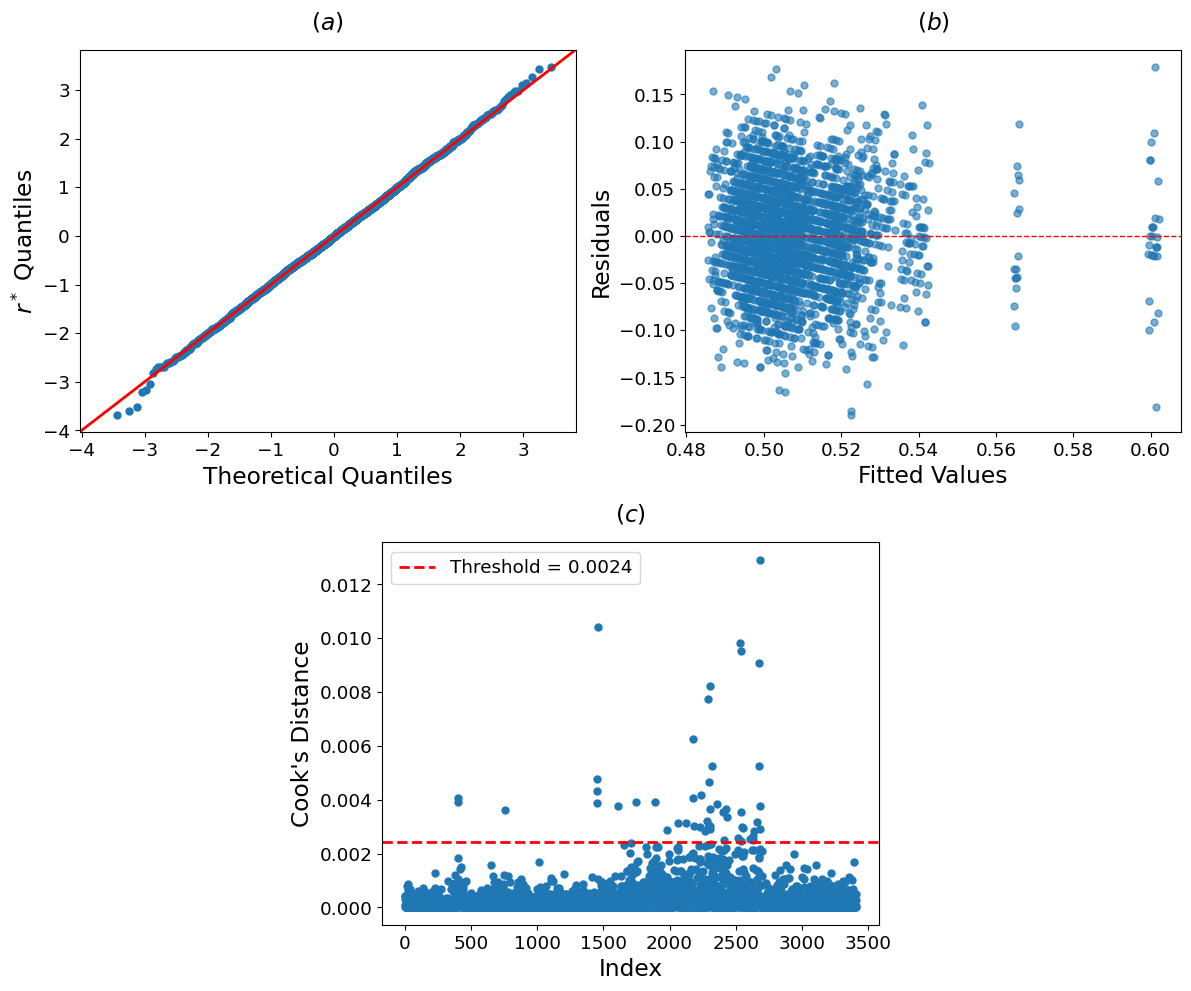

In [10]:
from statsmodels.api import qqplot
from matplotlib.gridspec import GridSpec

# Assume data_expanded and model are already defined
WLS_model_complete = sm.WLS.from_formula(
    formula="(rom) ~ 1 + C(person) + agg", 
    weights=data_expanded["weights"]/np.mean(data_expanded["weights"]),  
    data=data_expanded 
)     

result_WLS_complete = WLS_model_complete.fit()

# Residuals and Fitted Values
residuals_complete = result_WLS_complete.resid
fitted_values_complete = result_WLS_complete.fittedvalues
standardized_residuals_complete = result_WLS_complete.resid_pearson

# Cook's Distance
influence = OLSInfluence(result_WLS_complete)
cooks, _ = influence.cooks_distance
p_complete = result_WLS_complete.df_model
n_complete = len(fitted_values_complete)
threshold_complete = 8 / (n_complete - 2 * p_complete)
#threshold_complete = threshold_complete / np.mean((data_expanded["weights"]))
#print(np.mean(residuals_complete**2))

# Create the figure with subplots
fig = plt.figure(figsize=(12, 10), layout='tight')

gs = GridSpec(2, 4, figure=fig, )
ax1 = fig.add_subplot(gs[0,0:2])
ax2 = fig.add_subplot(gs[0,2:])
ax3 = fig.add_subplot(gs[1,1:-1])

# QQ Plot (subplot 1)
qqplot(residuals_complete, line='45', ax=ax1, fit=True)
ax1.set_title('$(a)$', pad=15)
ax1.set_ylabel('$r^*$ Quantiles')

# Residuals vs Fitted Values (subplot 2)
ax2.scatter(fitted_values_complete, residuals_complete, alpha=0.6)
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_title('$(b)$', pad=15)
ax2.set_xlabel('Fitted Values')
ax2.set_ylabel('Residuals')

# Cook's Distance (subplot 3)
ax3.scatter(range(len(cooks)), cooks)
ax3.axhline(threshold_complete, color='red', linestyle='--', label=f"Threshold = {threshold_complete:.4f}")
ax3.set_title("$(c)$", pad=15)
ax3.set_xlabel('Index')
ax3.set_ylabel("Cook's Distance")
ax3.legend()

# Adjust layout and show
plt.tight_layout()
plt.savefig('../figures/WLS_diagnostics.png', dpi=300)
plt.show()

In [11]:
# extract the only extreme cook :
influential_points = cooks > threshold_complete # Get the indices of the points with Cook's distance exceeding the threshold
influential_data = data_expanded[influential_points]

influential_data = influential_data[['person', 'coin', 'agg']]

# Print the results
print(f"Points with excessive Cook's distance (greater than {threshold_complete:.4f}):")
print(influential_data)


Points with excessive Cook's distance (greater than 0.0024):
                 person     coin  agg
488             madlenH  0.50EUR   29
490             madlenH  0.50EUR   31
842               jillR  0.20EUR   58
1538              irmaT     1EUR    1
1540              irmaT     1EUR    3
1541              irmaT     1EUR    4
1544              irmaT     1EUR    7
1699           JasonNak  0.20EUR    5
1829  KatharinaKarnbach     1GBP   13
1977        RietvanBork  0.05EUR   10
2065           AaronLob     2EUR   12
2153       AdrianKarami     2EUR   26
2211           ArneJohn     5SEK    6
2262            BohanFu  0.20EUR   18
2264            BohanFu  0.02EUR   20
2270                 EJ     2EUR    4
2313    FranziskaAssion     1EUR    6
2325    FranziskaAssion     1DEM   18
2354    HannahArmstrong     2CAD    9
2365    HannahArmstrong     1CAD   20
2374    HannahArmstrong     1CAD   29
2377            JanYang  0.50EUR    2
2382            JanYang  0.50EUR    7
2387            JanYang  0.

In [12]:
X_complete = WLS_model_complete.exog  # Design matrix
W_complete = np.diag(WLS_model_complete.weights)  # Diagonal weight matrix
n_complete = X_complete.shape[0]  
p_complete = X_complete.shape[1] 
print(p_complete)
print(np.linalg.matrix_rank(X_complete))


48
48


<Figure size 800x600 with 0 Axes>

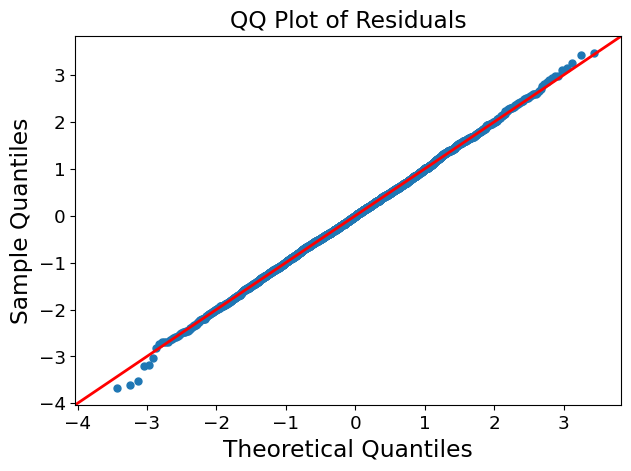

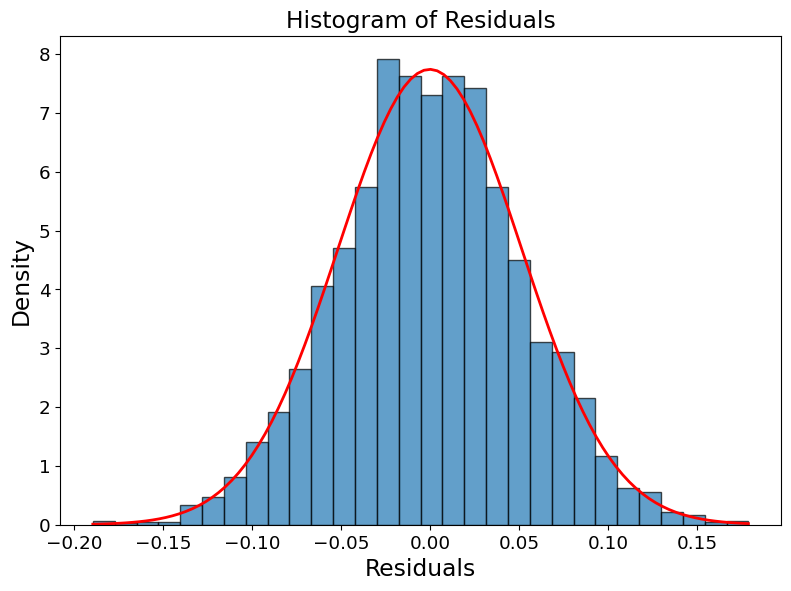

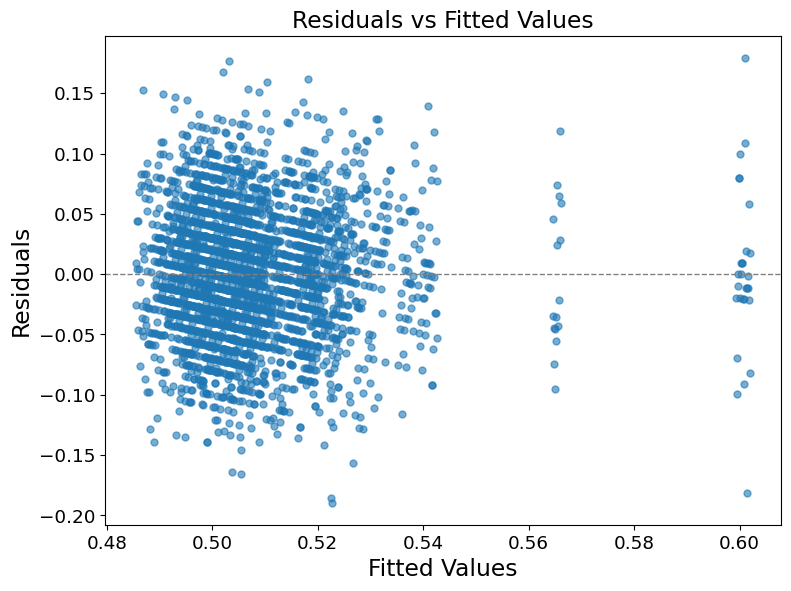

NameError: name 'p' is not defined

In [13]:
import scipy.stats as stats

# Extract residuals and fitted values
residuals_complete = result_WLS_complete.resid # actual values minus the predicted value
fitted_values_complete = result_WLS_complete.fittedvalues # ok predicted values 
standardized_residuals_complete = residuals_complete / np.std(residuals_complete) # standardized residuals
 

# QQ Plot (Normality of residuals)
plt.figure(figsize=(8, 6))
sm.qqplot(residuals_complete, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

# Histogram of Residuals (Check for normality)
plt.figure(figsize=(8, 6))
plt.hist(residuals_complete, bins=30, edgecolor='black', alpha=0.7, density=True)
# Overlay normal distribution
x = np.linspace(residuals_complete.min(), residuals_complete.max(), 100)
plt.plot(x, stats.norm.pdf(x, loc=np.mean(residuals_complete), scale=np.std(residuals_complete)), color='red')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values_complete, residuals_complete, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# ----------------------------------------------------------------------------------------------------
# COOK'S MEASURE : 
# ----------------------------------------------------------------------------------------------------
# Extract model data
X_complete = WLS_model_complete.exog  # Design matrix
W_complete = np.diag(WLS_model_complete.weights)  # Diagonal weight matrix
n_complete = X_complete.shape[0]  
p_complete = X_complete.shape[1] 

# matrix H
H_complete = W_complete @ X_complete @ np.linalg.inv(X_complete.T @ W_complete @ X_complete) @ X_complete.T @ W_complete
leverage_complete = np.diag(H_complete)  # diagonal of H, the hjj's in the slides

# Cook distance
standardized_residuals_complete = residuals_complete / np.std(residuals_complete)
cooks_d_complete= (standardized_residuals_complete**2 * leverage_complete) / (p * (1 - leverage_complete))
# check :::: cooks_d = (standardized_residuals**2 * leverage) / (p * (1 - leverage)**2)

# Threshold for Cook's Distance
threshold_complete = 8 / (n_complete - 2 * p_complete)

# Plot Cook's Distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_d_complete)), cooks_d_complete)  
plt.title("Cook's Distance for Influential Points")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.axhline(y=threshold_complete, color='red', linestyle='--', label=f"Threshold (8/(n-2p)) = {threshold:.4f}")
plt.legend()
plt.tight_layout()
plt.show()

influential_points_complete = np.where(cooks_d_complete > threshold_complete)[0] # extreme points 
print(f"Influential points (index): {influential_points_complete}")

# Plot of the big figure !

/Users/rayan/Documents/GitHub/reg-project/code/utils.py:108: RuntimeWarning: invalid value encountered in sqrt
  davison_resid = resid_pea


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/rayan/Documents/GitHub/reg-project/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/fd/plcsl8g53jj2g19ljhctv5_m0000gn/T/ipykernel_71530/10796137.py", line 4, in <module>
    ax = residual_vs_covariate( result_WLS_4, data, is_wls=True )
  File "/Users/rayan/Documents/GitHub/reg-project/code/utils.py", line 126, in residual_vs_covariate
  File "/Users/rayan/Documents/GitHub/reg-project/venv/lib/python3.9/site-packages/seaborn/categorical.py", line 1634, in boxplot
    p.plot_boxes(
  File "/Users/rayan/Documents/GitHub/reg-project/venv/lib/python3.9/site-packages/seaborn/categorical.py", line 700, in plot_boxes
    artists = ax.bxp(**boxplot_kws)
  File "/Users/rayan/Documents/GitHub/reg-project/venv/lib/python3.9/site-packages/matplotlib/axes/_axes.py", line 4350, in bxp
    raise ValueError(datashape_message.format("posit

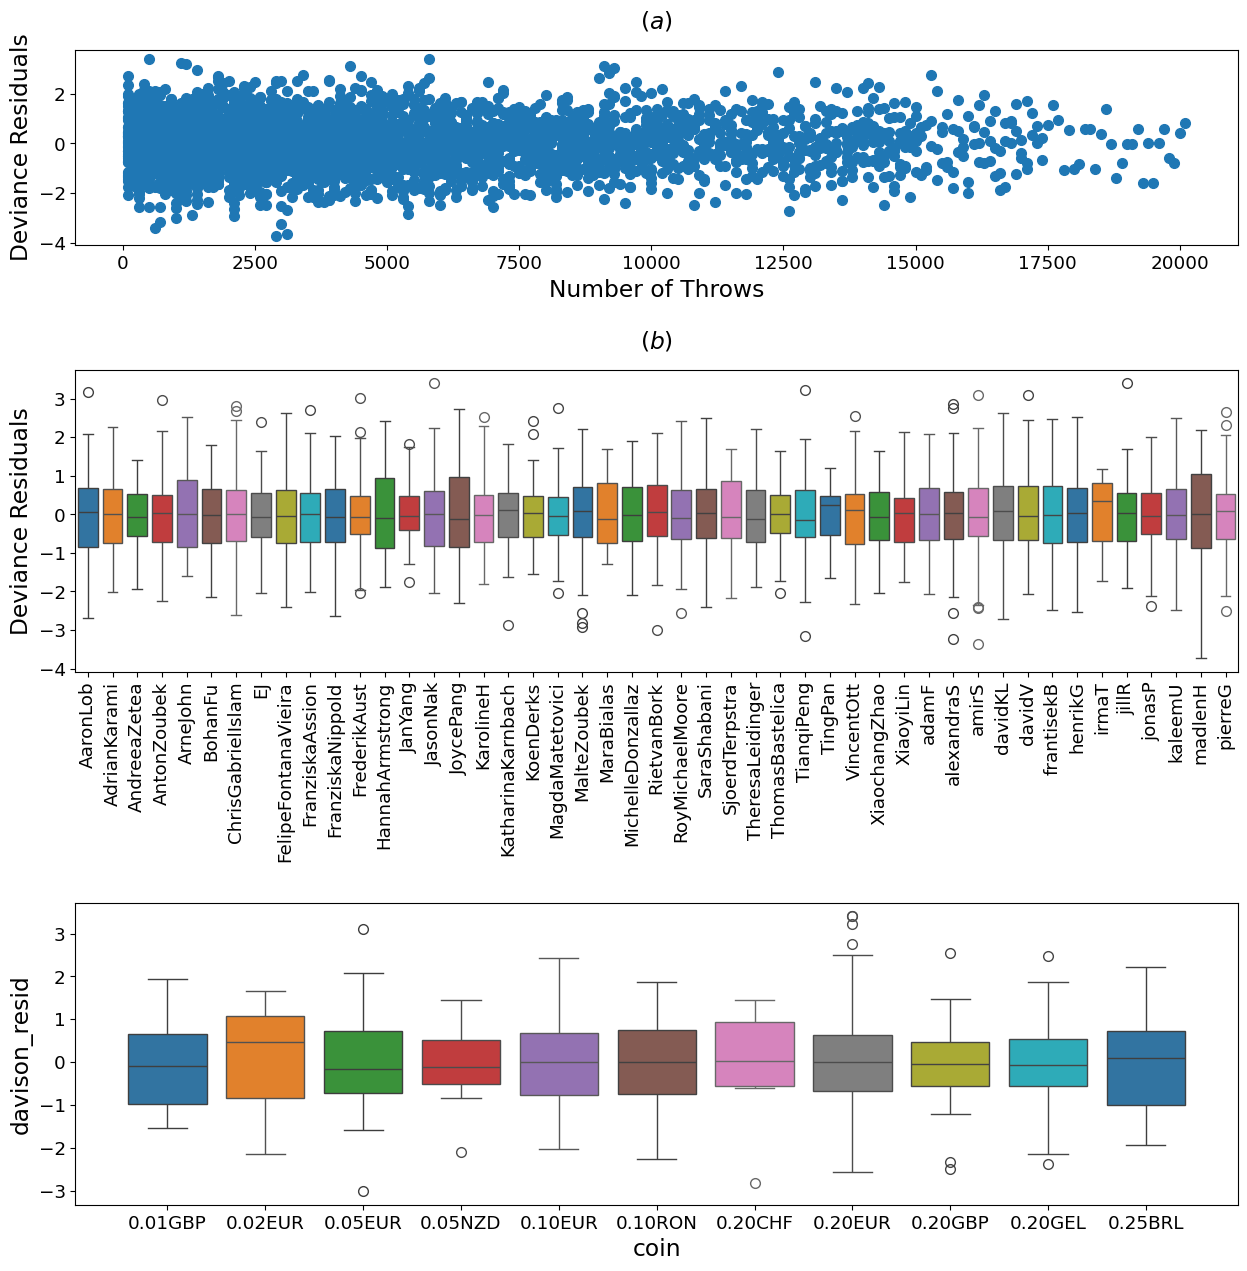

In [84]:
ax = residual_vs_covariate( result_WLS_4 , data , is_wls=True )
plt.savefig('../figures/wls_resid_vs_covariates.png', dpi=300)